### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge , Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
plt.rcParams['figure.figsize'] = (22, 14)






In [3]:
df_train=pd.read_csv("fraudTrain.csv",index_col="Unnamed: 0")
df_test=pd.read_csv("fraudTest.csv",index_col="Unnamed: 0")


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [4]:
#First delete features that  looking not relevant
df_train=df_train.drop(['first','last'],axis=1)
df_test=df_test.drop(['first','last'],axis=1)


In [5]:
df_train['day_of_trans']=pd.DatetimeIndex(df_train['trans_date_trans_time']).day_name()
df_train['hour_trans'] = pd.DatetimeIndex(df_train['trans_date_trans_time']).hour

df_test['day_of_trans']=pd.DatetimeIndex(df_test['trans_date_trans_time']).day_name()
df_test['hour_trans'] = pd.DatetimeIndex(df_test['trans_date_trans_time']).hour

In [6]:
df_train.gender.value_counts()

F    709863
M    586812
Name: gender, dtype: int64

In [7]:
df_train.gender[df_train['is_fraud'] == 1].value_counts()

M    3771
F    3735
Name: gender, dtype: int64

In [8]:
df_train = df_train.drop(['gender'],axis=1)
df_test = df_test.drop(['gender'],axis=1)

Text(0.5, 1.0, 'number of Frauds by day')

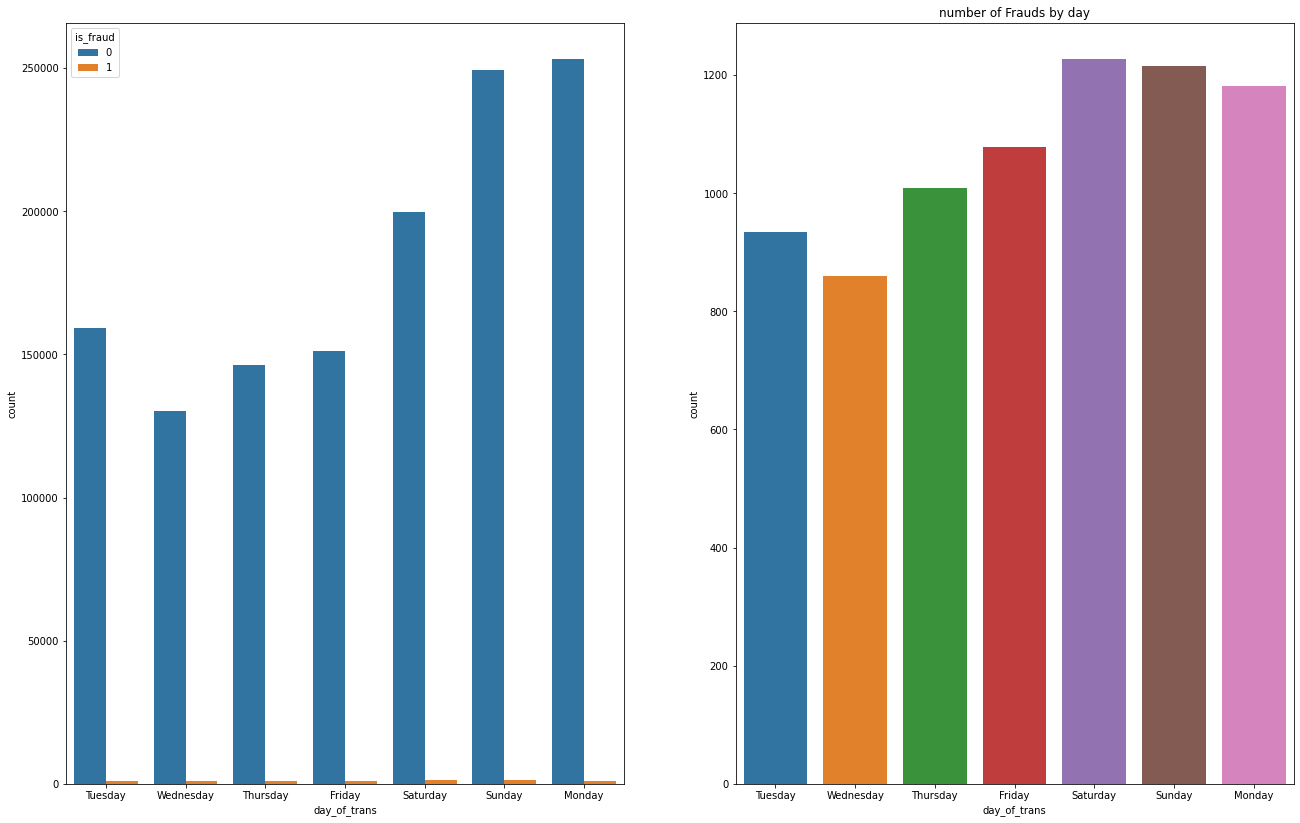

In [9]:
f, axes = plt.subplots(1, 2)
sns.countplot(x='day_of_trans', hue="is_fraud", data=df_train ,order = df_train.day_of_trans.unique(), ax=axes[0])
sns.countplot(x='day_of_trans',data=df_train[df_train['is_fraud'] == 1],order = df_train.day_of_trans.unique(), ax=axes[1]).set_title("number of Frauds by day")

Text(0.5, 1.0, 'number of Frauds')

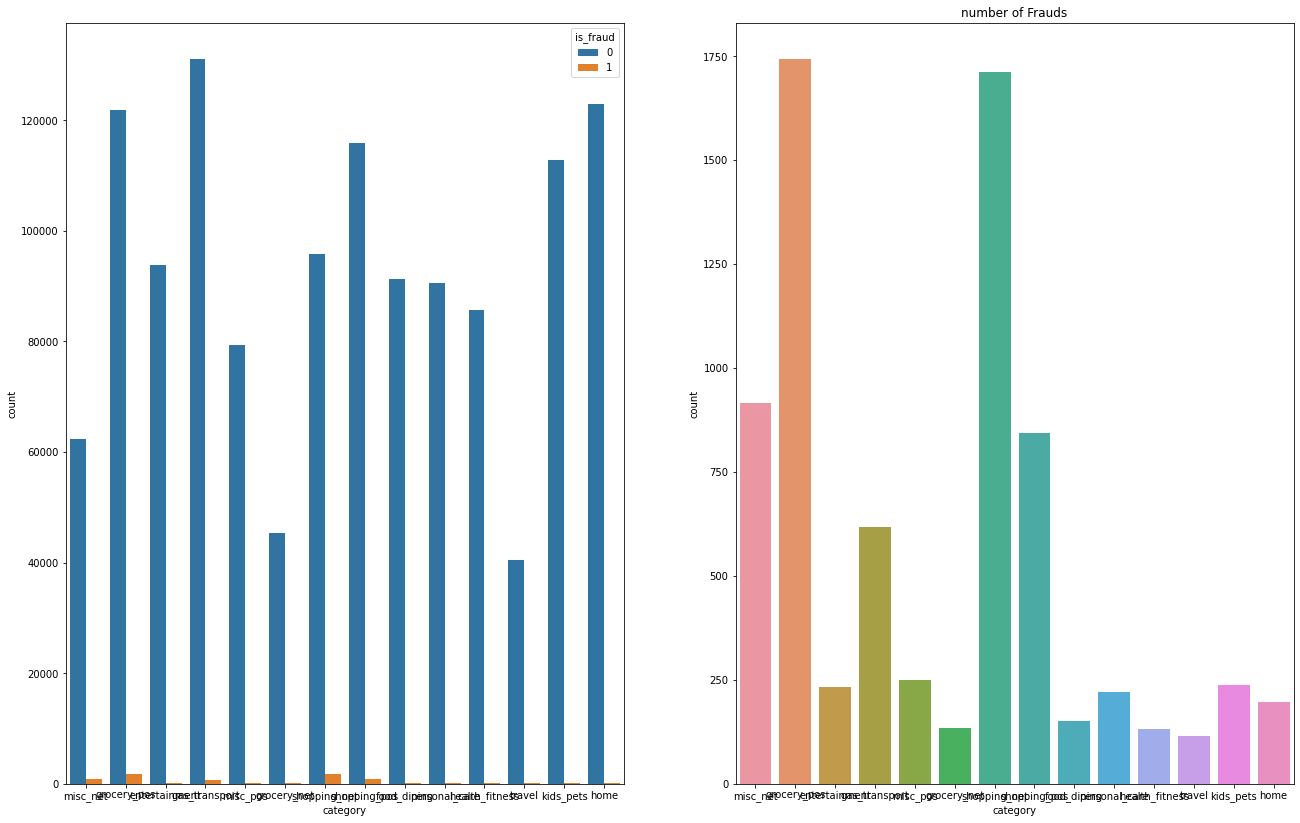

In [10]:
f, axes = plt.subplots(1, 2)
sns.countplot(x='category', hue="is_fraud", data=df_train ,order = df_train.category.unique(), ax=axes[0])
sns.countplot(x='category',data=df_train[df_train['is_fraud'] == 1],order = df_train.category.unique(), ax=axes[1]).set_title("number of Frauds")

In [11]:
df_merchant=df_train[['merchant','trans_num','is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()
df_merchant_test=df_test[['merchant','trans_num','is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()

In [12]:

df_merchant=df_merchant.loc[df_merchant['is_fraud']==1]
df_merchant_test=df_merchant_test.loc[df_merchant_test['is_fraud']==1]


In [13]:
df_merchant=df_merchant.drop(['is_fraud'],axis=1)
df_merchant_test=df_merchant_test.drop(['is_fraud'],axis=1)

In [14]:
df_merchant=df_merchant.rename(columns={'trans_num':"merchant_fraud"})
df_merchant_test=df_merchant_test.rename(columns={'trans_num':"merchant_fraud"})

In [15]:
df_trans_hour=df_train[['hour_trans','trans_num','is_fraud']]
df_trans_hour_test=df_test[['hour_trans','trans_num','is_fraud']]


In [16]:
df_trans_hour=df_trans_hour.groupby(['hour_trans','is_fraud']).count().reset_index()
df_trans_hour_test=df_trans_hour_test.groupby(['hour_trans','is_fraud']).count().reset_index()


In [17]:
df_trans_hour=df_trans_hour.sort_values(by=['trans_num'],ascending=False)
df_trans_hour=df_trans_hour.loc[df_trans_hour['is_fraud']==1]

df_trans_hour_test=df_trans_hour_test.sort_values(by=['trans_num'],ascending=False)
df_trans_hour_test=df_trans_hour_test.loc[df_trans_hour_test['is_fraud']==1]


In [18]:
df_trans_hour=df_trans_hour.rename(columns={'trans_num':"fraud_trans_in_hour"})
df_trans_hour_test=df_trans_hour_test.rename(columns={'trans_num':"fraud_trans_in_hour"})

In [19]:
df_trans_hour=df_trans_hour.drop(['is_fraud'],axis=1)
df_trans_hour_test=df_trans_hour_test.drop(['is_fraud'],axis=1)

In [20]:
df_trans_hour_test

,hour_trans,fraud_trans_in_hour
45,22,550
47,23,538
7,3,194
1,0,188
3,1,169
5,2,168
41,20,36
37,18,30
43,21,27
39,19,24


Text(0.5, 1.0, 'number of Frauds_per_hour')

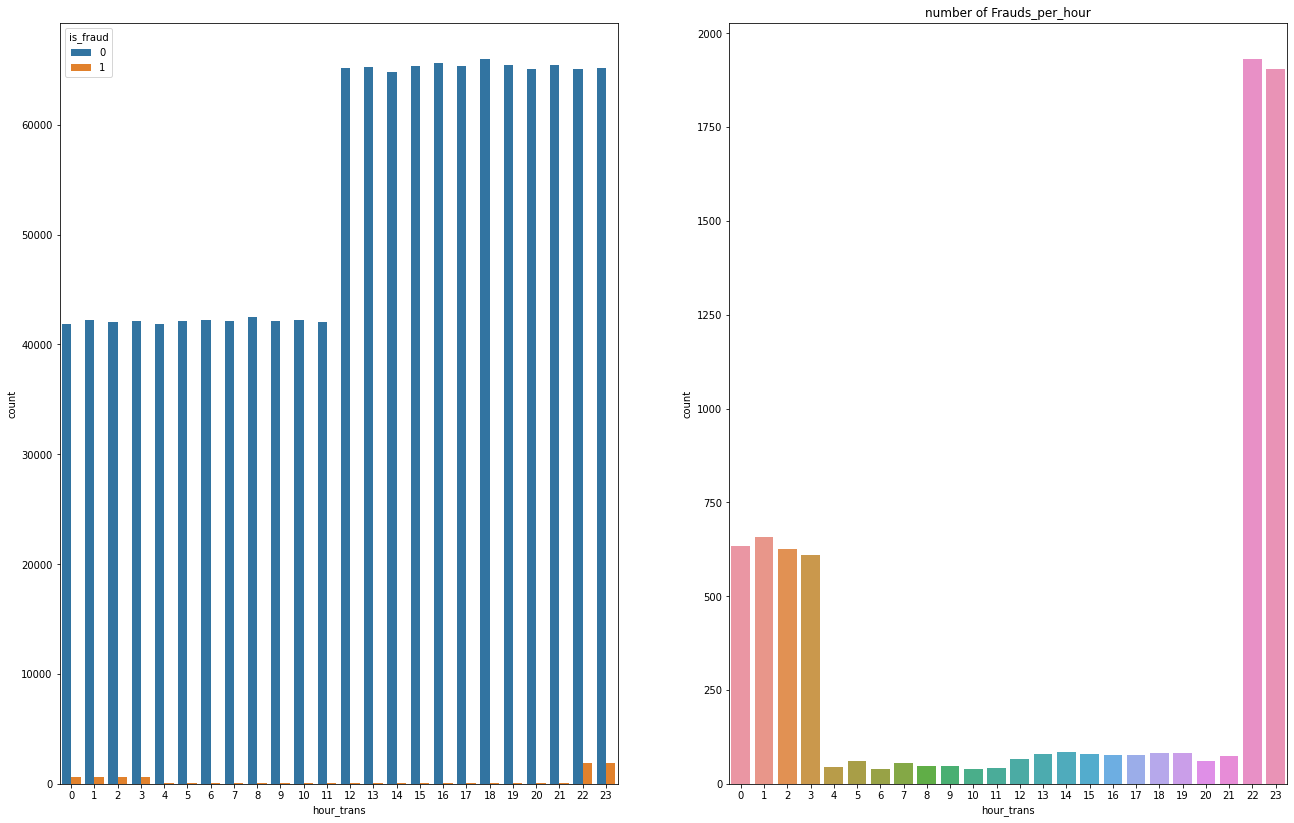

In [21]:
f, axes = plt.subplots(1, 2)
sns.countplot(x='hour_trans', hue="is_fraud", data=df_train ,order = df_train.hour_trans.unique(), ax=axes[0])
sns.countplot(x='hour_trans',data=df_train[df_train['is_fraud'] == 1],order = df_train.hour_trans.unique(), ax=axes[1]).set_title("number of Frauds_per_hour")

In [22]:
df_hour_dummies=pd.get_dummies(df_train['hour_trans'],prefix='hour')
df_hour_dummies_test=pd.get_dummies(df_train['hour_trans'],prefix='hour')

In [23]:
df_hour_dummies=df_hour_dummies.drop(df_hour_dummies.iloc[:,:-2].columns,axis=1)
df_hour_dummies_test=df_hour_dummies_test.drop(df_hour_dummies_test.iloc[:,:-2].columns,axis=1)

In [24]:
df_cc_num=df_train[['cc_num','is_fraud','trans_num']]
df_cc_num_test=df_test[['cc_num','is_fraud','trans_num']]

In [25]:
df_cc_num=df_cc_num.groupby(['cc_num','is_fraud']).count().reset_index()
df_cc_num_test=df_cc_num_test.groupby(['cc_num','is_fraud']).count().reset_index()

In [26]:
df_cc_num=df_cc_num.sort_values(by=['trans_num'],ascending=False)
df_cc_num=df_cc_num.loc[df_cc_num['is_fraud']==1]

df_cc_num_test=df_cc_num_test.sort_values(by=['trans_num'],ascending=False)
df_cc_num_test=df_cc_num_test.loc[df_cc_num_test['is_fraud']==1]


In [27]:
df_cc_num=df_cc_num.rename(columns={'trans_num':"fraud_per_cc"})
df_cc_num_test=df_cc_num_test.rename(columns={'trans_num':"fraud_per_cc"})

In [28]:
df_cc_num=df_cc_num.drop(['is_fraud'],axis=1)
df_cc_num_test=df_cc_num_test.drop(['is_fraud'],axis=1)

In [29]:
df_train.category.value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

In [30]:
df_test.category.value_counts()

gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel            17449
Name: category, dtype: int64

In [31]:
df_category=df_train[['category','is_fraud','trans_num']]
df_category=df_category.groupby(['category','is_fraud']).count().reset_index()
df_category=df_category.loc[df_category['is_fraud']==1]

In [32]:
df_category.sort_values(by='trans_num',)

,category,is_fraud,trans_num
27,travel,1,116
11,health_fitness,1,133
7,grocery_net,1,134
3,food_dining,1,151
13,home,1,198
21,personal_care,1,220
1,entertainment,1,233
15,kids_pets,1,239
19,misc_pos,1,250
5,gas_transport,1,618


In [33]:
df_category_dummies=pd.get_dummies(df_train['category'])
df_category_dummies_test=pd.get_dummies(df_test['category'])

df_category_dummies=df_category_dummies[['grocery_pos','shopping_net','misc_net','shopping_pos','gas_transport']]
df_category_dummies_test=df_category_dummies[['grocery_pos','shopping_net','misc_net','shopping_pos','gas_transport']]

In [34]:
df_state=df_train[['state','is_fraud','trans_num']]
df_state_test=df_test[['state','is_fraud','trans_num']]

In [35]:
df_state=df_state.groupby(['state','is_fraud']).count().reset_index()
df_state_test=df_state_test.groupby(['state','is_fraud']).count().reset_index()



In [36]:
df_state=df_state.sort_values(by=['trans_num'],ascending=False)
df_state=df_state.loc[df_state['is_fraud']==1]

df_state_test=df_state_test.sort_values(by=['trans_num'],ascending=False)
df_state_test=df_state_test.loc[df_state_test['is_fraud']==1]

In [37]:
df_state=df_state.rename(columns={'trans_num':"fraud_per_state"})
df_state_test=df_state_test.rename(columns={'trans_num':"fraud_per_state"})

In [38]:
df_state=df_state.rename(columns={'trans_num':"fraud_per_state"})
df_state_test=df_state_test.rename(columns={'trans_num':"fraud_per_state"})


In [39]:
df_state=df_state.drop(['is_fraud'],axis=1)
df_state_test=df_state_test.drop(['is_fraud'],axis=1)

In [40]:
df_job=df_train[['job','is_fraud','trans_num']]
df_job_test=df_test[['job','is_fraud','trans_num']]

In [41]:
df_job=df_job.groupby(['job','is_fraud']).count().reset_index()
df_job_test=df_job_test.groupby(['job','is_fraud']).count().reset_index()

In [42]:
df_job=df_job.sort_values(by=['trans_num'],ascending=False)
df_job=df_job.loc[df_job['is_fraud']==1]

df_job_test=df_job_test.sort_values(by=['trans_num'],ascending=False)
df_job_test=df_job_test.loc[df_job_test['is_fraud']==1]

In [43]:
df_job=df_job.rename(columns={'trans_num':"fraud_per_job"})
df_job_test=df_job_test.rename(columns={'trans_num':"fraud_per_job"})

In [44]:
df_job=df_job.drop(['is_fraud'],axis=1)
df_job_test=df_job_test.drop(['is_fraud'],axis=1)

In [45]:
df_train['distance']=np.sqrt( (df_train.lat-df_train.merch_lat)**2 + (df_train.long-df_train.merch_long)**2)
df_test['distance']=np.sqrt( (df_test.lat-df_test.merch_lat)**2 + (df_test.long-df_test.merch_long)**2)

df_train=df_train.drop(['lat','long','merch_lat','merch_long'],axis=1)
df_test=df_test.drop(['lat','long','merch_lat','merch_long'],axis=1)

In [46]:
# df_train['dob'] = pd.to_datetime(df_train['dob'])
# df_train['buy_date'] = pd.to_datetime(df_train['unix_time'],unit='s')
# df_train['buy_year'] = pd.DatetimeIndex(df_train['buy_date']).year
# df_train['buy_month'] = pd.DatetimeIndex(df_train['buy_date']).month
# df_train['buy_hour'] = pd.DatetimeIndex(df_train['buy_date']).hour
# df_train['buy_day'] = pd.DatetimeIndex(df_train['buy_date']).day
# df_train['buy_day_of_weak'] = pd.DatetimeIndex(df_train['buy_date']).dayofweek
# df_train['customer_age'] = np.round((df_train['buy_date'] - df_train['dob'])/np.timedelta64(1,'Y'))

# df_test['dob'] = pd.to_datetime(df_test['dob'])
# df_test['buy_date'] = pd.to_datetime(df_test['unix_time'],unit='s')
# df_test['buy_year'] = pd.DatetimeIndex(df_test['buy_date']).year
# df_test['buy_month'] = pd.DatetimeIndex(df_test['buy_date']).month
# df_test['buy_hour'] = pd.DatetimeIndex(df_test['buy_date']).hour
# df_test['buy_day'] = pd.DatetimeIndex(df_test['buy_date']).day
# df_test['buy_day_of_weak'] = pd.DatetimeIndex(df_test['buy_date']).dayofweek
# df_test['customer_age'] = np.round((df_test['buy_date'] - df_train['dob'])/np.timedelta64(1,'Y'))

In [47]:
df_numeric_train=df_train.select_dtypes(exclude=['object'])
df_numeric_test=df_test.select_dtypes(exclude=['object'])

In [48]:
y_train=df_train['is_fraud']
y_test=df_test['is_fraud']

df_numeric_test=df_numeric_test.drop(['is_fraud'],axis=1)
df_numeric_train=df_numeric_train.drop(['is_fraud'],axis=1)

In [49]:
df_numeric_train

,cc_num,amt,zip,city_pop,unix_time,hour_trans,distance
0,2703186189652095,4.97,28654,3495,1325376018,0,0.872830
1,630423337322,107.23,99160,149,1325376044,0,0.272310
2,38859492057661,220.11,83252,4154,1325376051,0,0.975845
3,3534093764340240,45.00,59632,1939,1325376076,0,0.919802
4,375534208663984,41.96,24433,99,1325376186,0,0.868505
...,...,...,...,...,...,...,...
1296670,30263540414123,15.56,84735,258,1371816728,12,1.177732
1296671,6011149206456997,51.70,21790,100,1371816739,12,0.819632
1296672,3514865930894695,105.93,88325,899,1371816752,12,0.967541
1296673,2720012583106919,74.90,57756,1126,1371816816,12,0.898775


In [50]:
df_numeric_train=pd.concat([df_numeric_train,df_hour_dummies,df_category_dummies],axis=1).reindex(df_numeric_train.index)
df_numeric_test=pd.concat([df_numeric_test,df_hour_dummies_test,df_category_dummies_test],axis=1).reindex(df_numeric_test.index)


In [51]:
df_numeric_train

,cc_num,amt,zip,city_pop,unix_time,hour_trans,distance,hour_22,hour_23,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport
0,2703186189652095,4.97,28654,3495,1325376018,0,0.872830,0,0,0,0,1,0,0
1,630423337322,107.23,99160,149,1325376044,0,0.272310,0,0,1,0,0,0,0
2,38859492057661,220.11,83252,4154,1325376051,0,0.975845,0,0,0,0,0,0,0
3,3534093764340240,45.00,59632,1939,1325376076,0,0.919802,0,0,0,0,0,0,1
4,375534208663984,41.96,24433,99,1325376186,0,0.868505,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,15.56,84735,258,1371816728,12,1.177732,0,0,0,0,0,0,0
1296671,6011149206456997,51.70,21790,100,1371816739,12,0.819632,0,0,0,0,0,0,0
1296672,3514865930894695,105.93,88325,899,1371816752,12,0.967541,0,0,0,0,0,0,0
1296673,2720012583106919,74.90,57756,1126,1371816816,12,0.898775,0,0,0,0,0,0,0


In [52]:
df_temp_train=df_numeric_train.drop(['cc_num','unix_time','hour_trans'],axis=1)
df_temp_test=df_numeric_test.drop(['cc_num','unix_time','hour_trans'],axis=1)

In [53]:
df_temp_train

,amt,zip,city_pop,distance,hour_22,hour_23,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport
0,4.97,28654,3495,0.872830,0,0,0,0,1,0,0
1,107.23,99160,149,0.272310,0,0,1,0,0,0,0
2,220.11,83252,4154,0.975845,0,0,0,0,0,0,0
3,45.00,59632,1939,0.919802,0,0,0,0,0,0,1
4,41.96,24433,99,0.868505,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,84735,258,1.177732,0,0,0,0,0,0,0
1296671,51.70,21790,100,0.819632,0,0,0,0,0,0,0
1296672,105.93,88325,899,0.967541,0,0,0,0,0,0,0
1296673,74.90,57756,1126,0.898775,0,0,0,0,0,0,0


In [54]:
y_train=df_train['is_fraud']

In [55]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(df_temp_train, y_train)

In [56]:
df_temp_train

,amt,zip,city_pop,distance,hour_22,hour_23,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport
0,4.97,28654,3495,0.872830,0,0,0,0,1,0,0
1,107.23,99160,149,0.272310,0,0,1,0,0,0,0
2,220.11,83252,4154,0.975845,0,0,0,0,0,0,0
3,45.00,59632,1939,0.919802,0,0,0,0,0,0,1
4,41.96,24433,99,0.868505,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,84735,258,1.177732,0,0,0,0,0,0,0
1296671,51.70,21790,100,0.819632,0,0,0,0,0,0,0
1296672,105.93,88325,899,0.967541,0,0,0,0,0,0,0
1296673,74.90,57756,1126,0.898775,0,0,0,0,0,0,0


In [57]:

y_test=df_test["is_fraud"]

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_smote,y_train_smote)
y_pred=logreg.predict(df_temp_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[460747  92827]
 [   537   1608]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    553574
           1       0.02      0.75      0.03      2145

    accuracy                           0.83    555719
   macro avg       0.51      0.79      0.47    555719
weighted avg       1.00      0.83      0.90    555719



In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

lr = LinearRegression()
logreg.fit(X_train_smote,y_train_smote)
y_pred=logreg.predict(df_temp_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[460747  92827]
 [   537   1608]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    553574
           1       0.02      0.75      0.03      2145

    accuracy                           0.83    555719
   macro avg       0.51      0.79      0.47    555719
weighted avg       1.00      0.83      0.90    555719



## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

In [60]:
df_final_train=df_train.merge(df_merchant,on='merchant',how='left')
df_final_test=df_test.merge(df_merchant_test,on='merchant',how='left')

In [61]:
df_final_train['merchant_fraud']=df_final_train['merchant_fraud'].fillna(0)
df_final_test['merchant_fraud']=df_final_test['merchant_fraud'].fillna(0)

In [62]:
df_final_train=df_final_train.merge(df_cc_num,on='cc_num',how='left')
df_final_test=df_final_test.merge(df_cc_num_test,on='cc_num',how='left')

In [63]:
df_final_train['fraud_per_cc']=df_final_train['fraud_per_cc'].fillna(0)
df_final_test['fraud_per_cc']=df_final_test['fraud_per_cc'].fillna(0)


In [64]:
df_final_train=df_final_train.merge(df_state,on='state',how='left')
df_final_test=df_final_test.merge(df_state_test,on='state',how='left')

In [65]:
df_final_train['fraud_per_state']=df_final_train['fraud_per_state'].fillna(0)
df_final_test['fraud_per_state']=df_final_test['fraud_per_state'].fillna(0)

In [66]:
df_final_train=df_final_train.merge(df_job,on='job',how='left')
df_final_test=df_final_test.merge(df_job_test,on='job',how='left')

In [67]:
df_final_train['fraud_per_job']=df_final_train['fraud_per_job'].fillna(0)
df_final_test['fraud_per_job']=df_final_test['fraud_per_job'].fillna(0)

In [68]:
df_temp1_train=df_final_train[['merchant_fraud','fraud_per_cc','fraud_per_state','fraud_per_job']]
df_temp1_test=df_final_test[['merchant_fraud','fraud_per_cc','fraud_per_state','fraud_per_job']]

In [69]:
df_numeric_train=pd.concat([df_numeric_train,df_temp1_train],axis=1).reindex(df_numeric_train.index)
df_numeric_test=pd.concat([df_numeric_test,df_temp1_test],axis=1).reindex(df_numeric_test.index)

In [70]:
df_final_numerical=df_numeric_train.drop(['cc_num','unix_time'],axis=1)
df_final_numerical_test=df_numeric_test.drop(['cc_num','unix_time'],axis=1)

In [71]:
df_final_numerical

,amt,zip,city_pop,hour_trans,distance,hour_22,hour_23,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport,merchant_fraud,fraud_per_cc,fraud_per_state,fraud_per_job
0,4.97,28654,3495,0,0.872830,0,0,0,0,1,0,0,18.0,0.0,149,6.0
1,107.23,99160,149,0,0.272310,0,0,1,0,0,0,0,27.0,0.0,96,11.0
2,220.11,83252,4154,0,0.975845,0,0,0,0,0,0,0,4.0,0.0,11,8.0
3,45.00,59632,1939,0,0.919802,0,0,0,0,0,0,1,9.0,15.0,32,20.0
4,41.96,24433,99,0,0.868505,0,0,0,0,0,0,0,6.0,0.0,198,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,84735,258,12,1.177732,0,0,0,0,0,0,0,5.0,9.0,61,30.0
1296671,51.70,21790,100,12,0.819632,0,0,0,0,0,0,0,4.0,8.0,157,8.0
1296672,105.93,88325,899,12,0.967541,0,0,0,0,0,0,0,2.0,11.0,82,53.0
1296673,74.90,57756,1126,12,0.898775,0,0,0,0,0,0,0,4.0,8.0,74,8.0


In [72]:
sm  = SMOTE()
X_train_oversampled, y_train_oversampled  = sm .fit_resample(df_final_numerical, y_train)

In [73]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_oversampled,y_train_oversampled)
y_pred=logreg.predict(df_final_numerical_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[479498  74076]
 [   532   1613]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    553574
           1       0.02      0.75      0.04      2145

    accuracy                           0.87    555719
   macro avg       0.51      0.81      0.48    555719
weighted avg       1.00      0.87      0.92    555719



In [93]:
df_train['dob'] = pd.to_datetime(df_train['dob'])
df_train['buy_date'] = pd.to_datetime(df_train['unix_time'],unit='s')
df_train['customer_age'] = np.round((df_train['buy_date'] - df_train['dob'])/np.timedelta64(1,'Y'))
df_test['dob'] = pd.to_datetime(df_test['dob'])
df_test['buy_date'] = pd.to_datetime(df_test['unix_time'],unit='s')
df_test['customer_age'] = np.round((df_test['buy_date'] - df_train['dob'])/np.timedelta64(1,'Y'))

In [94]:
df_train

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,city_pop,job,dob,trans_num,unix_time,is_fraud,day_of_trans,hour_trans,distance,buy_date,customer_age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,0,Tuesday,0,0.872830,2012-01-01 00:00:18,24.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,0,Tuesday,0,0.272310,2012-01-01 00:00:44,34.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0,Tuesday,0,0.975845,2012-01-01 00:00:51,50.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,0,Tuesday,0,0.919802,2012-01-01 00:01:16,45.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0,Tuesday,0,0.868505,2012-01-01 00:03:06,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,162 Jessica Row Apt. 072,Hatch,UT,84735,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,0,Sunday,12,1.177732,2013-06-21 12:12:08,52.0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,0,Sunday,12,0.819632,2013-06-21 12:12:19,34.0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,0,Sunday,12,0.967541,2013-06-21 12:12:32,46.0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,42933 Ryan Underpass,Manderson,SD,57756,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,0,Sunday,12,0.898775,2013-06-21 12:13:36,33.0


In [95]:
df_day_trans_dummies=pd.get_dummies(df_train['day_of_trans'])
df_day_trans_dummies_test=pd.get_dummies(df_test['day_of_trans'])

In [75]:
df_merchant = df_train.groupby(by="merchant").sum()['is_fraud']

In [76]:
fraud_merchant=df_merchant[df_merchant>35].index.to_list()

In [77]:
df_merchant_dummies=pd.get_dummies(df_train['merchant'])
df_merchant_dummies_test=pd.get_dummies(df_test['merchant'])

In [78]:
df_merchant_dummies=df_merchant_dummies[fraud_merchant]
df_merchant_dummies_test=df_merchant_dummies_test[fraud_merchant]

In [97]:
df_final_train=pd.concat([df_train,df_hour_dummies,df_category_dummies,df_day_trans_dummies],axis=1).reindex(df_train.index)
df_final_test=pd.concat([df_test,df_hour_dummies_test,df_category_dummies_test,df_day_trans_dummies_test],axis=1).reindex(df_test.index)

In [98]:
df_final_train=df_final_train.select_dtypes(exclude=['object'])
df_final_test=df_final_test.select_dtypes(exclude=['object'])

In [102]:
df_final_train.head().T

,0,1,2,3,4
cc_num,2703186189652095,630423337322,38859492057661,3534093764340240,375534208663984
amt,4.97,107.23,220.11,45,41.96
zip,28654,99160,83252,59632,24433
city_pop,3495,149,4154,1939,99
dob,1988-03-09 00:00:00,1978-06-21 00:00:00,1962-01-19 00:00:00,1967-01-12 00:00:00,1986-03-28 00:00:00
unix_time,1325376018,1325376044,1325376051,1325376076,1325376186
is_fraud,0,0,0,0,0
hour_trans,0,0,0,0,0
distance,0.87283,0.27231,0.975845,0.919802,0.868505
buy_date,2012-01-01 00:00:18,2012-01-01 00:00:44,2012-01-01 00:00:51,2012-01-01 00:01:16,2012-01-01 00:03:06


In [103]:
df_final_train=df_final_train.drop(['cc_num','zip','unix_time','hour_22','hour_23','dob','buy_date'],axis=1)
df_final_test=df_final_test.drop(['cc_num','zip','unix_time','hour_22','hour_23','dob','buy_date'],axis=1)


In [104]:
df_final_train

,amt,city_pop,is_fraud,hour_trans,distance,customer_age,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,4.97,3495,0,0,0.872830,24.0,0,0,1,0,0,0,0,0,0,0,1,0
1,107.23,149,0,0,0.272310,34.0,1,0,0,0,0,0,0,0,0,0,1,0
2,220.11,4154,0,0,0.975845,50.0,0,0,0,0,0,0,0,0,0,0,1,0
3,45.00,1939,0,0,0.919802,45.0,0,0,0,0,1,0,0,0,0,0,1,0
4,41.96,99,0,0,0.868505,26.0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,258,0,12,1.177732,52.0,0,0,0,0,0,0,0,0,1,0,0,0
1296671,51.70,100,0,12,0.819632,34.0,0,0,0,0,0,0,0,0,1,0,0,0
1296672,105.93,899,0,12,0.967541,46.0,0,0,0,0,0,0,0,0,1,0,0,0
1296673,74.90,1126,0,12,0.898775,33.0,0,0,0,0,0,0,0,0,1,0,0,0


In [120]:
y_train=df_final_train['is_fraud']
y_test=df_final_test['is_fraud']

x_train=df_final_train.drop(['is_fraud'],axis=1)
x_test=df_final_test.drop(['is_fraud'],axis=1)



In [106]:
print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(1296675, 17) (1296675,) (555719, 17) (555719,)


In [107]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [ ]:
x_train.info()

best param: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 150}
Train Results
6 150 sqrt
[[509437  44137]
 [   430   1715]]
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    553574
         1.0       0.04      0.80      0.07      2145

    accuracy                           0.92    555719
   macro avg       0.52      0.86      0.51    555719
weighted avg       1.00      0.92      0.95    555719



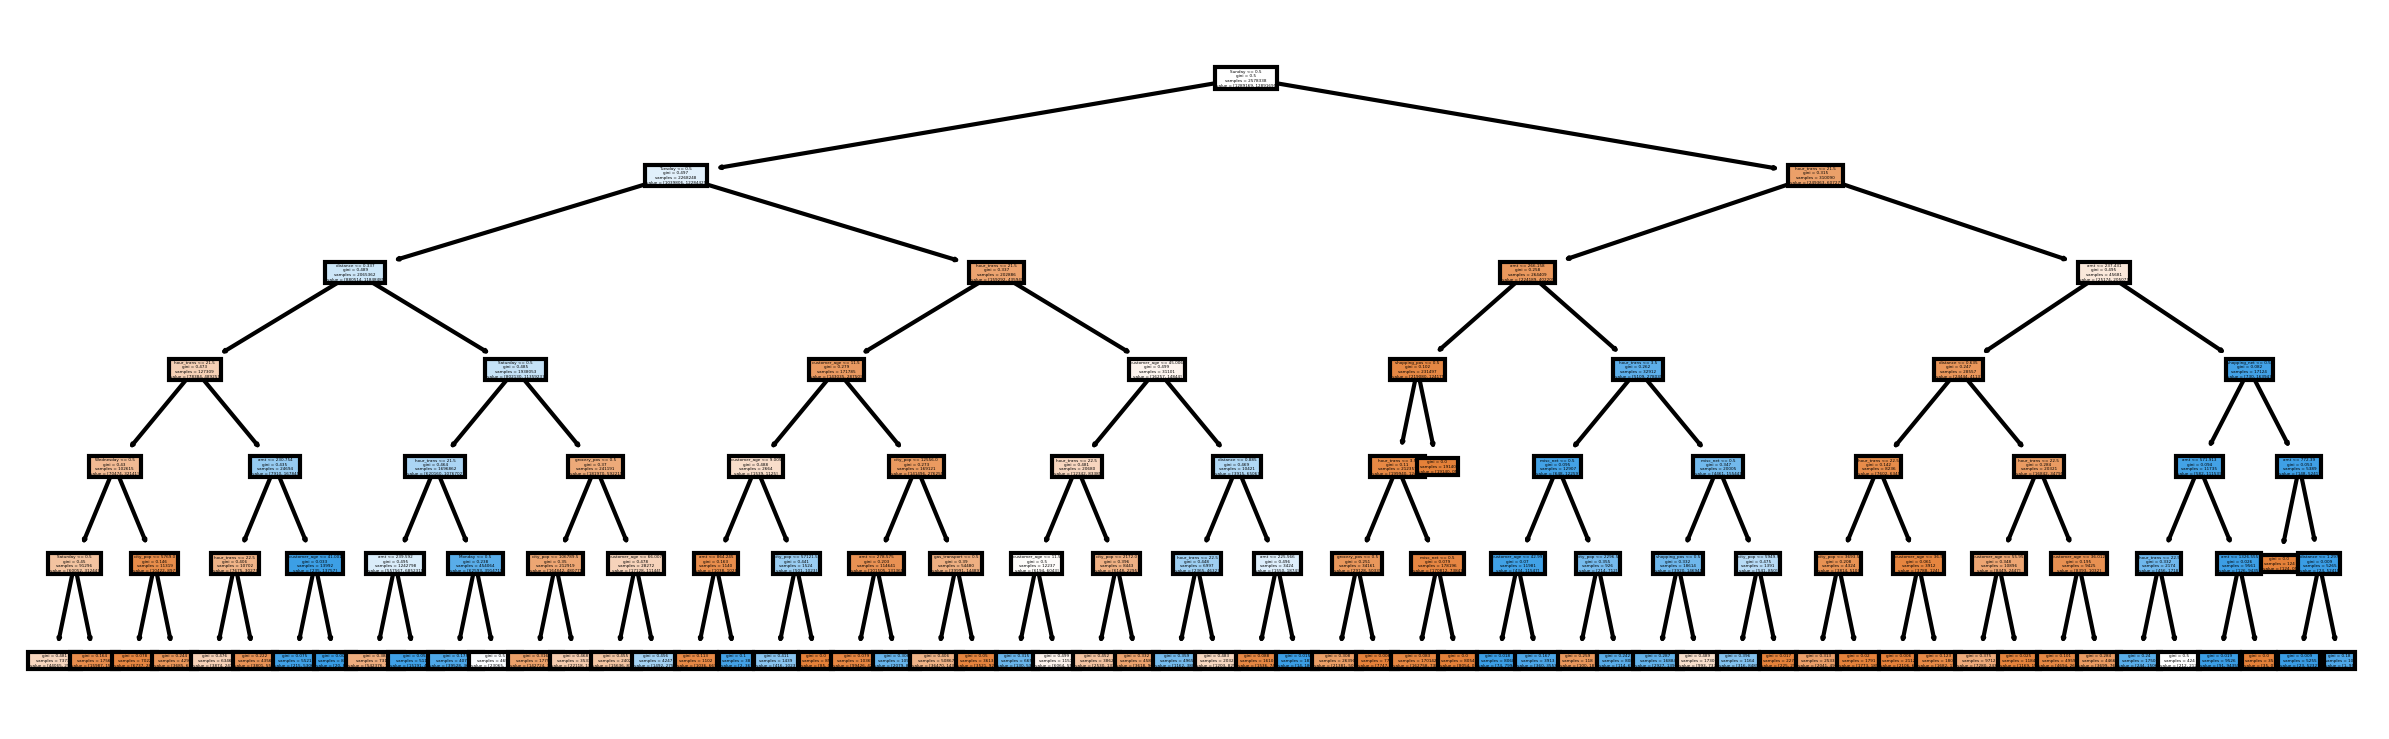

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
max_depth = range(2,7,2) #[4,5,6,7,8,9,10,11,12]
min_samples= range(150,3500,220)

decisionTree= DecisionTreeClassifier()
tree_para = {'max_depth':max_depth, 'min_samples_split':min_samples, 'max_features':['sqrt','log2']}

# # tree_para = {'criterion':['gini'],'max_depth':max_depth}
# clf = GridSearchCV(decisionTree, tree_para, cv=5)
# clf.fit(x_train, y_train)

# print('best param:', clf.best_params_)
# print("Train Results")
pred_train = clf.predict(x_test)



max_depth_decision_tree = clf.best_params_['max_depth']
min_samples_split_tree = clf.best_params_['min_samples_split']
max_features_tree = clf.best_params_['max_features']

print(max_depth_decision_tree,min_samples_split_tree,max_features_tree)

decisionTree = DecisionTreeClassifier(max_depth=6, min_samples_split=150, max_features='sqrt')

decisionTree.fit(x_train, y_train )
y_pred=decisionTree.predict(x_test)

print(confusion_matrix(y_test, pred_train))
print(classification_report(y_test, pred_train))

plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(decisionTree, feature_names=x_train.columns,filled=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(random_state=42)
# forest_param = { 
#     'max_features': ['sqrt', 'log2'],
#     'max_depth' : max_depth,
#     'min_samples_split': min_samples,
# }

# clf = GridSearchCV(forest, forest_param, cv=5)
# clf.fit(x_train, y_train)

# print('best param:', clf.best_params_)
# print("Train Results")
# pred_train = clf.predict(x_test)



# forect_best_gini = 'gini'
# forest_max_depth = clf.best_params_['max_depth']
# forest_max_features = clf.best_params_['max_features']
# forest_min_samples_split = clf.best_params_['min_samples_split']


#forest_max_depth = 6
#forest_min_samples_split = 35p
#forest_max_features = 'sqrt'

# print(forect_best_gini,forest_max_depth,forest_max_features, forest_min_samples_split)



forest=RandomForestClassifier(random_state=42,max_depth=6, min_samples_split=350, max_features= 'sqrt')

clf  = forest.fit(x_train, y_train )
pred_train=forest.predict(x_test)

print(confusion_matrix(y_test, pred_train))
print(classification_report(y_test, pred_train))

plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(forest.estimators_[0], feature_names=x_train.columns,filled=True)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [130]:
x_binary_train=pd.concat([df_hour_dummies,df_category_dummies,df_day_trans_dummies],axis=1).reindex(df_hour_dummies.index)
x_binary_test=pd.concat([df_hour_dummies_test,df_category_dummies_test,df_day_trans_dummies_test],axis=1).reindex(df_hour_dummies_test.index)



In [121]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_binary_train, y_train)

In [131]:
x_binary_test

,hour_22,hour_23,grocery_pos,shopping_net,misc_net,shopping_pos,gas_transport,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296671,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296672,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296673,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

# boosting_param = {'max_depth':max_depth, 'learning_rate':np.arange (0.1,1,0.2),'min_samples_split':min_samples, 'max_features': ['sqrt','log2'], 'criterion' :['friedman_mse', 'mse']}


# boosting = GradientBoostingClassifier(n_estimators=60,subsample=0.8, random_state=42)
# clf = GridSearchCV(boosting, boosting_param, cv=5)
# clf.fit(x_train, y_train)


# print('best param:', clf.best_params_)
# print("Train Results")
# pred_train = clf.predict(x_train)



# boosting_best_criterion = clf.best_params_['criterion']
# boosting_max_depth = clf.best_params_['max_depth']
# boosting_max_features = clf.best_params_['max_features']
# boosting_min_samples_split = clf.best_params_['min_samples_split']
# boosting_learning_rate = clf.best_params_['learning_rate']


# print(boosting_best_criterion,boosting_max_depth,boosting_max_features, boosting_min_samples_split, boosting_learning_rate)
# print(clf.grid_scores_, clf.best_params_, clf.best_score_)


# boosting=GradientBoostingClassifier(n_estimators=60,
#                                     subsample=0.8,
#                                     random_state=42,
#                                     criterion='friedman_mse',
#                                     max_depth=5,
#                                     max_features=10,
#                                     min_samples_split=2,
#                                     learning_rate=1.0)

gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=3, learning_rate=1.0)
gbrt.fit(x_train, y_train)
clf  = gbrt.fit(x_train, y_train )
pred_train=gbrt.predict(x_binary_test)


print(confusion_matrix(y_test, pred_train))
print(classification_report(y_test, pred_train))

plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(boosting.estimators_[0], feature_names=x_train.columns,filled=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

From the feature engineering we can take the relevant values and from the di

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.

The Best Clasificator was Decision tree. For this exercise the best deep was 6. How ever if try make this Clasificator deeper we can get best results. 
In our studies deep 20 can gives 0.99 